In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 65kB/s 
     |████████████████████████████████| 204kB 39.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=99d9596d9cda3cf6475601b4ce7b11c4de3390dadae7b625c89e297206fb0fdc
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
from __future__ import print_function

import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.linalg import Vectors


%matplotlib inline

print (pyspark.__version__)

3.0.1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
spark = SparkSession.builder.appName('cluster').getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/CC GENERAL.csv'
df = spark.read.csv(path,header=True,inferSchema=True)
df.show(10)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
| C10001|  40.900749|         0.818182|     95.4|             0.0|                  95.4|  

In [ ]:
feature = df.columns[1:]
feature

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [ ]:
df= df.na.drop()
df.show(10)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
| C10001|  40.900749|         0.818182|     95.4|             0.0|                  95.4|  

In [ ]:
df_feature = df.select(*(df[c].cast("float").alias(c) for c in df.columns[1:]))
df_feature.show()

+----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+---------+----------------+----------------+------+
|   BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT| PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+---------+----------------+----------------+------+
|  40.90075|         0.818182|     95.4|             0.0|                  95.4|         0.0|           0.166667|           

In [ ]:
for col in df.columns:
    if col in feature:
        df = df.withColumn(col,df[col].cast('float'))

df = df.na.drop()
df.show(10)

+-------+----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+---------+----------------+----------------+------+
|CUST_ID|   BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT| PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+---------+----------------+----------------+------+
| C10001|  40.90075|         0.818182|     95.4|             0.0|                  95.4|         0.0

In [ ]:
vec_assembler = VectorAssembler(inputCols = feature, outputCol='features')

In [ ]:
df_kmeans = vec_assembler.transform(df).select('CUST_ID', 'features')
df_kmeans.show(10)

+-------+--------------------+
|CUST_ID|            features|
+-------+--------------------+
| C10001|[40.9007492065429...|
| C10002|(17,[0,1,5,9,10,1...|
| C10003|[2495.14892578125...|
| C10005|[817.71435546875,...|
| C10006|[1809.82873535156...|
| C10007|[627.260803222656...|
| C10008|[1823.65270996093...|
| C10009|[1014.92645263671...|
| C10010|[152.225967407226...|
| C10011|[1293.125,1.0,920...|
+-------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(df_kmeans)
df_kmeans = scalerModel.transform(df_kmeans)

In [ ]:
# Training a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(df_kmeans)

centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.93850979 4.15643186 0.1192139  0.11948881 0.06240818 0.74596841
 0.39174134 0.28680961 0.18073943 1.0828694  0.76637406 0.11629306
 1.16668428 0.53760547 0.38772839 0.17736575 8.72664341]
[1.97545737 4.73766333 3.79084101 3.21251982 3.05920822 0.83393315
 2.34866564 2.3770214  1.99448726 0.64829984 0.67933487 3.71934983
 2.80220655 3.06638495 1.02371763 0.89466104 9.10659442]
[0.45617602 4.44717244 0.58607798 0.38175077 0.6840883  0.11735446
 2.10826056 0.99562948 1.68924373 0.22386564 0.1317287  0.87298277
 1.17641443 0.48279302 0.27888643 0.9203661  8.85330018]


In [ ]:
df_pred = model.transform(df_kmeans)
df_pred.show()

+-------+--------------------+--------------------+----------+
|CUST_ID|            features|      scaledFeatures|prediction|
+-------+--------------------+--------------------+----------+
| C10001|[40.9007492065429...|[0.01951770824959...|         0|
| C10002|(17,[0,1,5,9,10,1...|(17,[0,1,5,9,10,1...|         0|
| C10003|[2495.14892578125...|[1.19067718116272...|         2|
| C10005|[817.71435546875,...|[0.39021070594452...|         0|
| C10006|[1809.82873535156...|[0.86364455232706...|         2|
| C10007|[627.260803222656...|[0.29932687276418...|         1|
| C10008|[1823.65270996093...|[0.87024130931830...|         2|
| C10009|[1014.92645263671...|[0.48431969540038...|         0|
| C10010|[152.225967407226...|[0.07264175051813...|         0|
| C10011|[1293.125,1.0,920...|[0.61707516292197...|         2|
| C10012|[630.794738769531...|[0.30101325563772...|         0|
| C10013|[1516.92858886718...|[0.72387352817107...|         2|
| C10014|[921.693359375,1....|[0.43982915797036...|    

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(df_pred.features, df_pred.scaledFeatures, df_pred.prediction)
threedee.set_xlabel('feature')
threedee.set_ylabel('scaledFeatures')
threedee.set_zlabel('z')
plt.show()

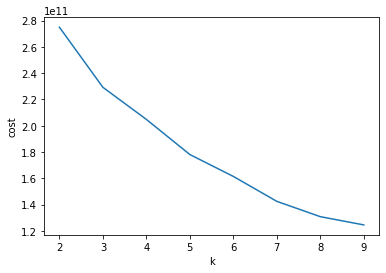

In [ ]:
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(df_kmeans)
    cost[k] = model.summary.trainingCost

# Plot the cost
dataset_cost = pd.DataFrame(cost[2:])
dataset_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
dataset_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(dataset_cost.cluster, dataset_cost.cost)
pl.xlabel('k')
pl.ylabel('cost')
pl.show()

In [ ]:
n_samples=10000
n_features=3
X, y = make_blobs(n_samples=n_samples, centers=10, n_features=n_features, random_state=42)

# add a row index as a string
pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
pddf['id'] = 'row'+pddf.index.astype(str)

#move it first (left)
cols = list(pddf)
cols.insert(0, cols.pop(cols.index('id')))
pddf = pddf.loc[:,cols]
pddf.head()

# save the ndarray as a csv file
pddf.to_csv('input.csv', index=False)

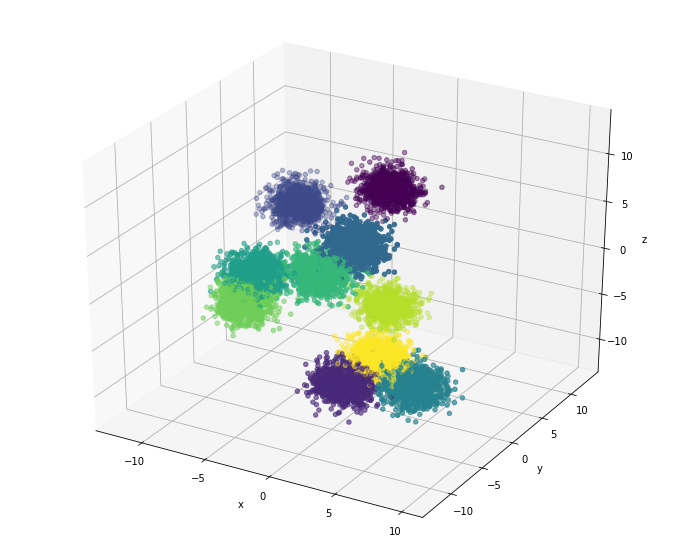

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c=y)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [ ]:
sc = SparkContext(appName="PythonKMeansExample") # exist by default
sqlContext = SQLContext(sc)

In [ ]:
FEATURES_COL = ['x', 'y', 'z']
path = 'input.csv'

In [ ]:
df = sqlContext.read.csv(path, header=True) # requires spark 2.0
df.show()

+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796| -6.798321268724102|
|row10|  -5.690284570490115| -6.482740258743004|-0.9246966808128123|
|row11|-0.01798614270656...|  2.76

In [ ]:
lines = sc.textFile(path)
data = lines.map(lambda line: line.split(","))
data.take(2)

[['id', 'x', 'y', 'z'],
 ['row0', '-6.077699676970267', '-2.9096103057273632', '-1.5181728865169748']]

In [ ]:
df = data.toDF(['id', 'x', 'y', 'z'])
print (df)
df.show()

DataFrame[id: string, x: string, y: string, z: string]
+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796|

In [ ]:
df_feat = df.select(*(df[c].cast("float").alias(c) for c in df.columns[1:]))
df_feat.show()

+------------+----------+----------+
|           x|         y|         z|
+------------+----------+----------+
|        null|      null|      null|
|  -6.0776997|-2.9096103|-1.5181729|
|  -1.0122601|  7.322841|-5.4424076|
|   -8.297007| 6.3228936| 1.1672047|
|  -3.5071216|  4.784812|-5.4449472|
|   -5.122823|-3.3220499|-0.5069805|
|  -2.4764006|  8.255791|  4.409478|
|   7.3153954| -5.079449| -7.291215|
|  -2.0167463|  9.303454|  7.095179|
|  -0.2338185| -4.892681| 2.1228876|
|    6.565442| -6.855994|-6.7983212|
|  -5.6902847|-6.4827404|-0.9246967|
|-0.017986143| 2.7632365| -8.814824|
|  -6.9042625|-6.1491723|-3.5354295|
|  -10.389865|  9.537853|  0.674591|
|   3.9688683|-6.0467844| -5.462389|
|   -7.337052|-3.7689247| -5.261122|
|   -8.991589|  8.738728|  3.864116|
| -0.18098584|  5.482743| -4.900118|
|   3.3193955|-6.3573766| -6.978025|
+------------+----------+----------+
only showing top 20 rows



In [ ]:
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
|   id|        null|      null|      null|
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
+-----+----

In [ ]:
df = df.na.drop()
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
|row19|  -2.0266335|-3.4171724|0.48218703|
+-----+----

In [ ]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+-----+--------------------+
|   id|            features|
+-----+--------------------+
| row0|[-6.0776996612548...|
| row1|[-1.0122600793838...|
| row2|[-8.2970066070556...|
| row3|[-3.5071215629577...|
| row4|[-5.1228232383728...|
| row5|[-2.4764006137847...|
| row6|[7.31539535522460...|
| row7|[-2.0167462825775...|
| row8|[-0.2338185012340...|
| row9|[6.56544208526611...|
|row10|[-5.6902847290039...|
|row11|[-0.0179861430078...|
|row12|[-6.9042625427246...|
|row13|[-10.389864921569...|
|row14|[3.96886825561523...|
|row15|[-7.3370518684387...|
|row16|[-8.9915885925292...|
|row17|[-0.1809858381748...|
|row18|[3.31939554214477...|
|row19|[-2.0266335010528...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.summary.predictions(df_kmeans) # requires Spark 2.0 or later

TypeError: ignored

Text(0, 0.5, 'cost')

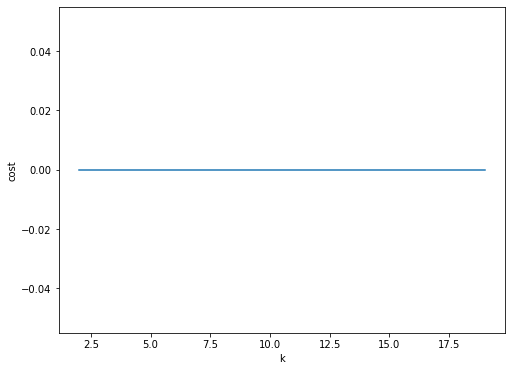

In [ ]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-4.9545928  -4.09830766  0.02879097]
[ 4.11111715 -9.61155031  9.41405178]
[ 5.93579074 -5.71109414 -6.70969645]
[-2.46074836  9.0641161   4.6330292 ]
[ 0.27991887  1.81322325 -9.14288007]
[-9.47218036  7.82671364  1.9099296 ]
[ 7.32675933 -5.68103661 -5.77495036]
[ 1.94977337 -6.97097176 -6.92765433]
[-0.90157747  5.71691605 -5.97326952]
[-8.14658277  6.80469316  2.09200704]


In [ ]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id='row0', prediction=0), Row(id='row1', prediction=8), Row(id='row2', prediction=9)]


In [ ]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+-----+----------+
|   id|prediction|
+-----+----------+
| row0|         0|
| row1|         8|
| row2|         9|
| row3|         8|
| row4|         0|
| row5|         3|
| row6|         2|
| row7|         3|
| row8|         0|
| row9|         2|
|row10|         0|
|row11|         4|
|row12|         0|
|row13|         5|
|row14|         2|
|row15|         0|
|row16|         5|
|row17|         8|
|row18|         7|
|row19|         0|
+-----+----------+
only showing top 20 rows



In [ ]:
df_pred = df_pred.join(df, 'id')
df_pred.show()

+-------+----------+----------+----------+----------+
|     id|prediction|         x|         y|         z|
+-------+----------+----------+----------+----------+
|row1093|         9| -7.601147|  7.069047|  1.564275|
|row1099|         0|-0.7107884|-3.3169584|  2.488001|
| row119|         0| -9.524287| -5.396073|-3.3982348|
|row1191|         4|-0.8568603|  2.037963|-10.700185|
|row1352|         8| -1.669029|  6.943214|-6.0198708|
|row1586|         6|  8.243615|-6.7687254| -6.591385|
|row1766|         1| 3.5482397|  -9.91293|  9.635929|
|row2684|         8|-0.5487077|    6.2472|-4.9076533|
|row2770|         3|-2.4884038| 8.2862835| 4.4569826|
|row2883|         6|  7.196379|-5.0276275| -4.923547|
|row3313|         8|-1.3719763| 4.7211256|-5.1501107|
| row332|         9|-7.6491013|  7.990768| 1.9940823|
|row3374|         4| 1.9008663| 2.4249678| -8.085093|
|row3376|         0|  -5.62288|-2.5612633|0.39997813|
|row4049|         0|-1.7804127|-4.6741023| 2.5568235|
|row4152|         9| -9.1510

In [ ]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x,y,z
id,,,,
row1093,9,-7.601147,7.069047,1.564275
row1099,0,-0.710788,-3.316958,2.488001
row119,0,-9.524287,-5.396073,-3.398235
row1191,4,-0.856860,2.037963,-10.700185
row1352,8,-1.669029,6.943214,-6.019871


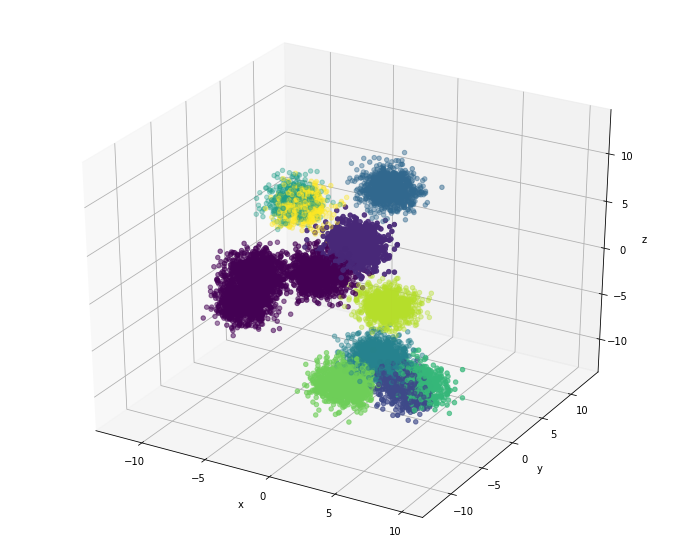

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [ ]:
sc.stop()